In [1]:
!pip install pandas
!pip install numpy

In [2]:
import pandas as pd
import os
import json
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [3]:
liwc_features = pd.read_csv('./LIWC2015 Results (data-kushal).csv')
liwc_features = liwc_features.drop(['Source (A)', 'Source (C)', 'Source (D)'], axis = 1)
liwc_features = liwc_features.rename(columns={'Source (B)': 'video_id'})
features = liwc_features.copy()
features = features.groupby('video_id').mean().reset_index()

In [4]:
# Read all the data
labels = []
labels_mapping = {}
label_count = 0
df = pd.read_csv('./raw_data.csv')

for index, row in df.iterrows():
    path = os.path.join('./processed_video', 'audio_' + row['video_id'] + '_txt')
    
    if os.path.isfile(path):
        with open(path, 'r') as f:
            try:
                file_data = json.load(f)
                labels.append((row['video_likeCount'] - row['video_dislikeCount'])/row['video_viewCount'])
                labels_mapping[row['video_id']] = label_count
                label_count = label_count + 1
                
            except ValueError:
                print(path + ' failed processing')

labels = np.array(labels)
print()
print('Shape of labels: ', labels.shape)

./processed_video/audio_xCgk9nvuCxk_txt failed processing
./processed_video/audio_Q_ouhkdo-ko_txt failed processing

Shape of labels:  (3389,)


In [5]:
label_series = pd.Series(labels)
print(label_series.value_counts(bins=20).sort_index())

(-0.021500000000000002, -0.0122]       1
(-0.0122, -0.00398]                    7
(-0.00398, 0.00421]                  225
(0.00421, 0.0124]                   1094
(0.0124, 0.0206]                    1021
(0.0206, 0.0288]                     613
(0.0288, 0.037]                      264
(0.037, 0.0452]                      103
(0.0452, 0.0533]                      31
(0.0533, 0.0615]                      17
(0.0615, 0.0697]                       5
(0.0697, 0.0779]                       2
(0.0779, 0.0861]                       1
(0.0861, 0.0943]                       1
(0.0943, 0.102]                        0
(0.102, 0.111]                         1
(0.111, 0.119]                         1
(0.119, 0.127]                         0
(0.127, 0.135]                         1
(0.135, 0.143]                         1
dtype: int64


In [6]:
# Prepare data for cnn lstm by concatenating frames, normalizing labels and defining constants
labels = np.clip(labels, 0.00421, 0.037)
min_label = np.min(labels)
max_label = np.max(labels)
scaled_labels = (labels - min_label)/(max_label - min_label)

In [7]:
for video_id, index in labels_mapping.items():
    features.loc[features.video_id == video_id, 'rating'] = scaled_labels[index]

In [8]:
print(features.columns)

Index(['video_id', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS',
       'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you',
       'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb',
       'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
       'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social',
       'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear',
       'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives',
       'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time',
       'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal',
       'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc', 'Period',
       'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote',
       'Apostro', 'Parenth', 'Other

In [9]:
scaler = preprocessing.MinMaxScaler()
features[['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS',
       'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you',
       'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb',
       'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
       'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social',
       'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear',
       'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives',
       'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time',
       'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal',
       'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc', 'Period',
       'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote',
       'Apostro', 'Parenth', 'OtherP']] = scaler.fit_transform(features[['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS',
       'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you',
       'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb',
       'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
       'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social',
       'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear',
       'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives',
       'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time',
       'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal',
       'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc', 'Period',
       'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote',
       'Apostro', 'Parenth', 'OtherP']])

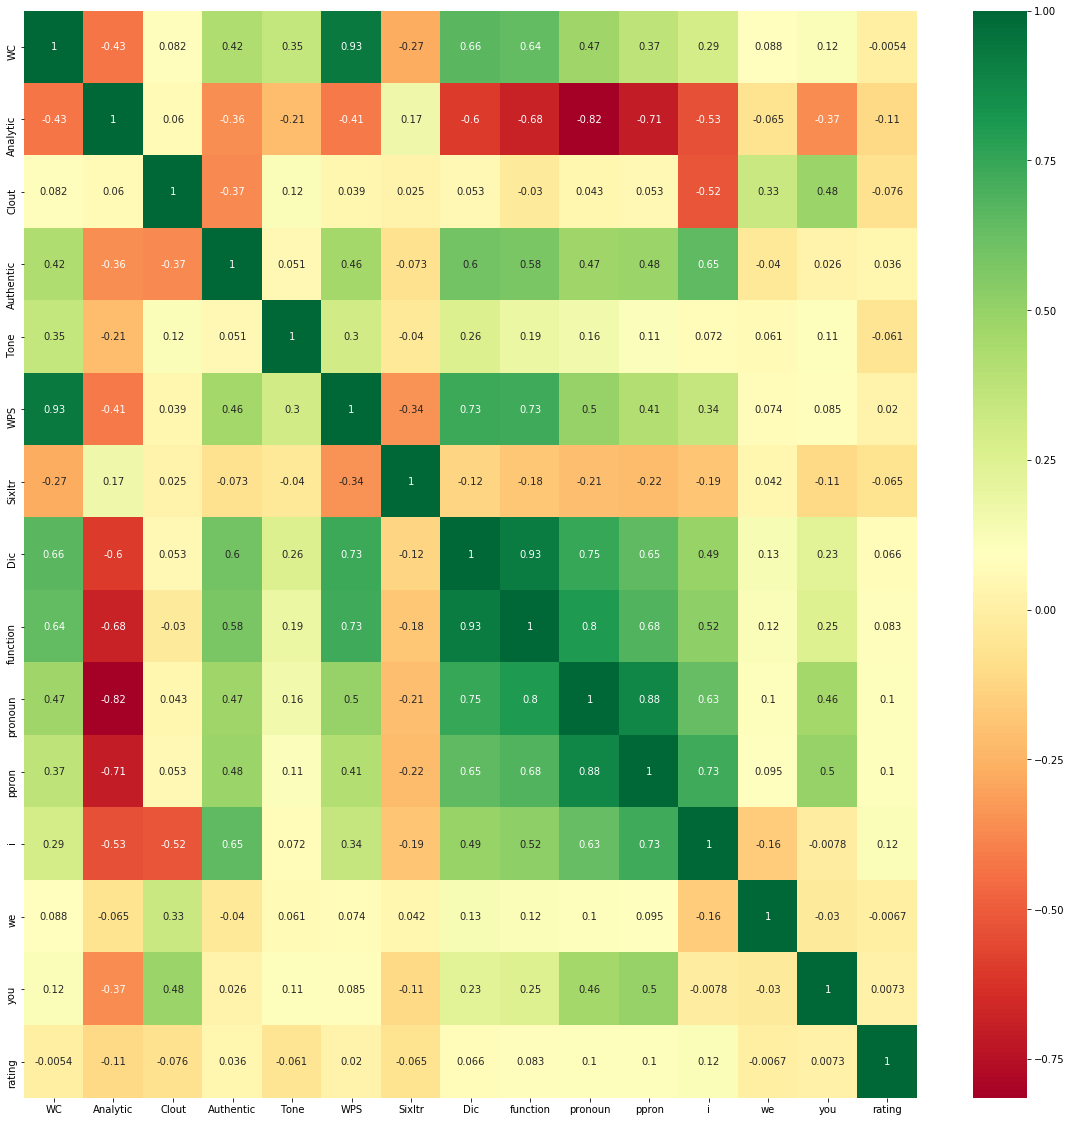

In [10]:
data = features[['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS',
       'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you',
       'rating']]
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

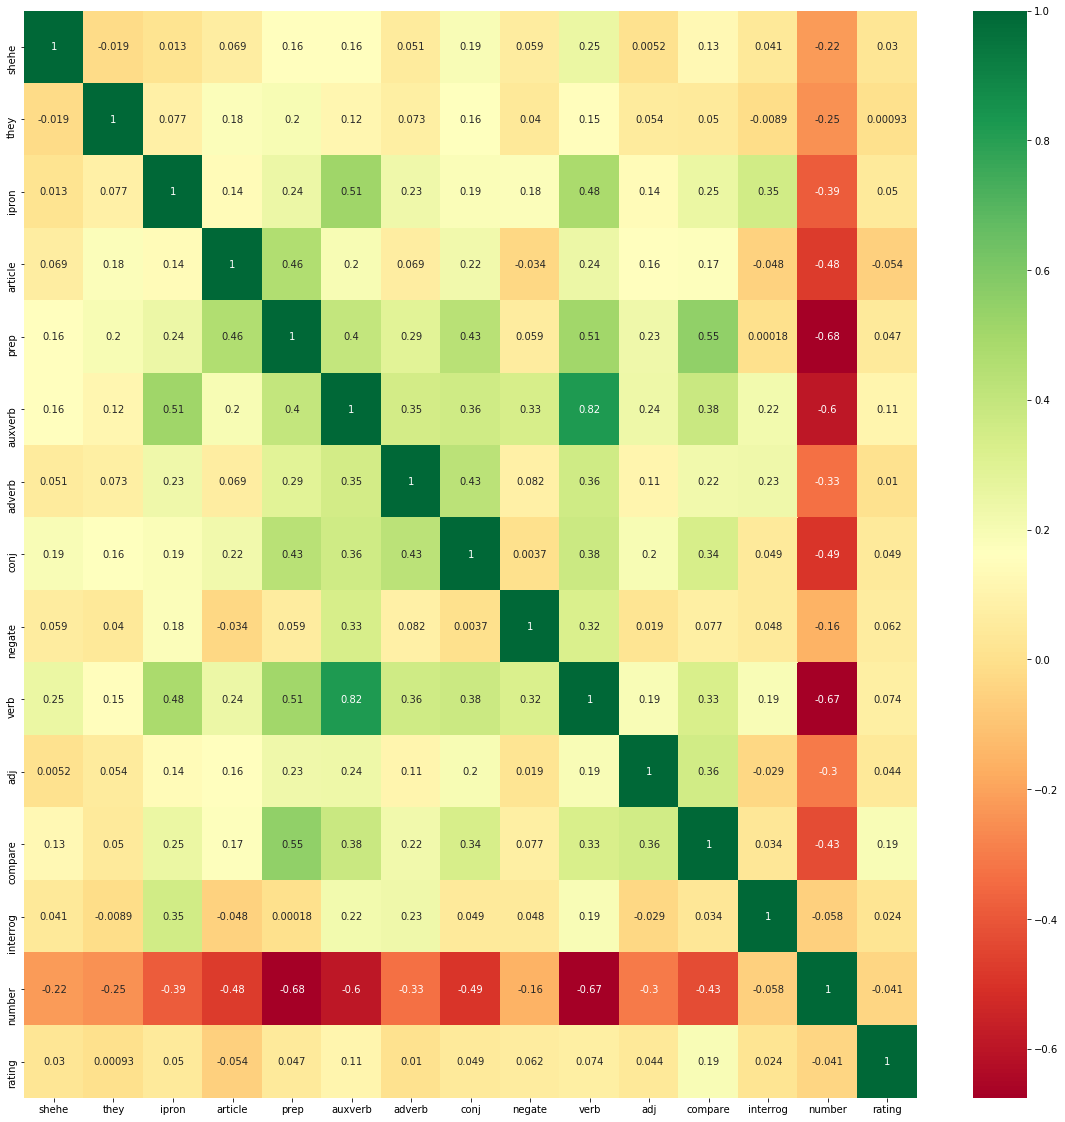

In [11]:
data = features [['shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb',
       'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
        'rating']]
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

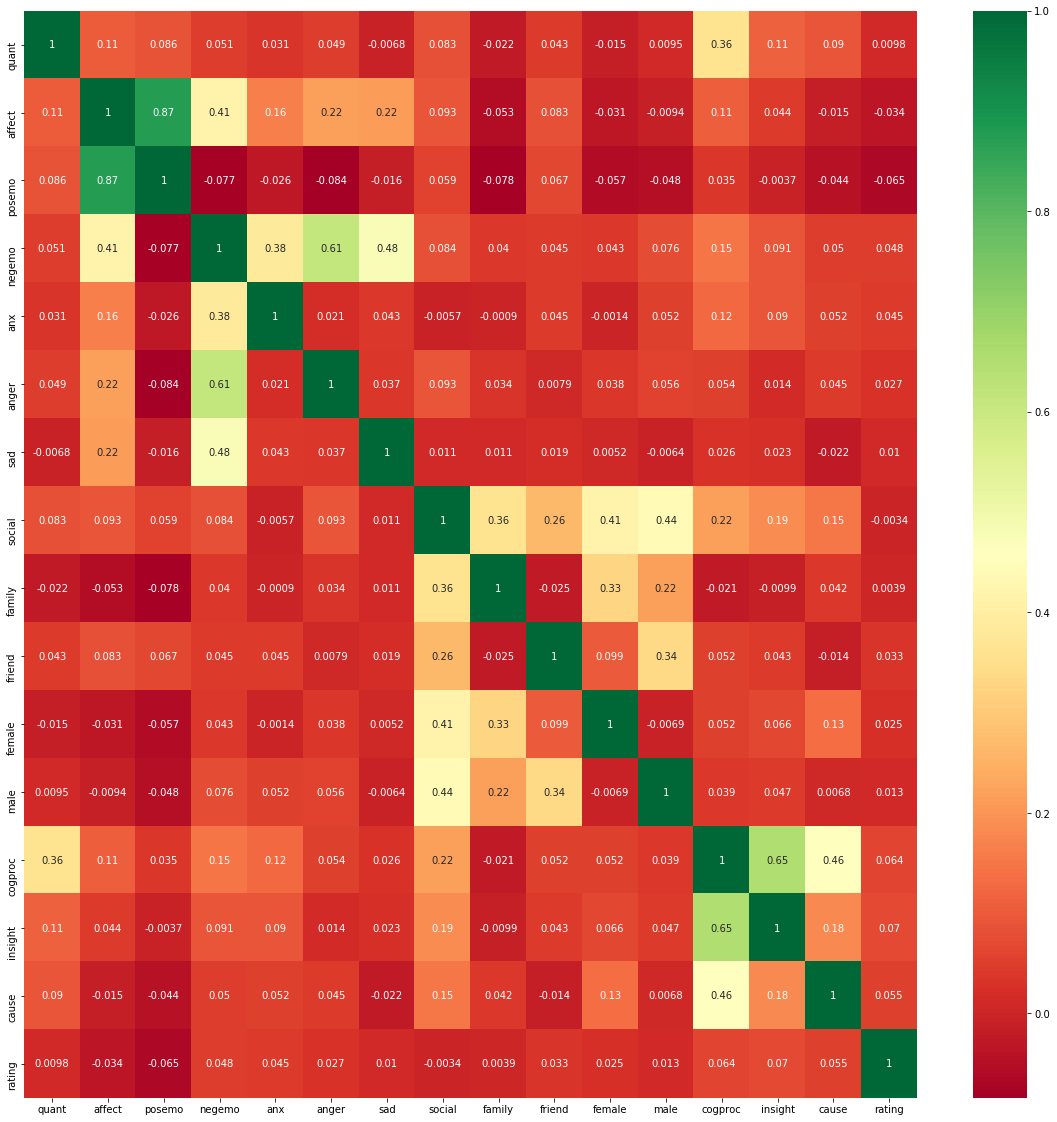

In [12]:
data = features[['quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social',
       'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause',
       'rating']]
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

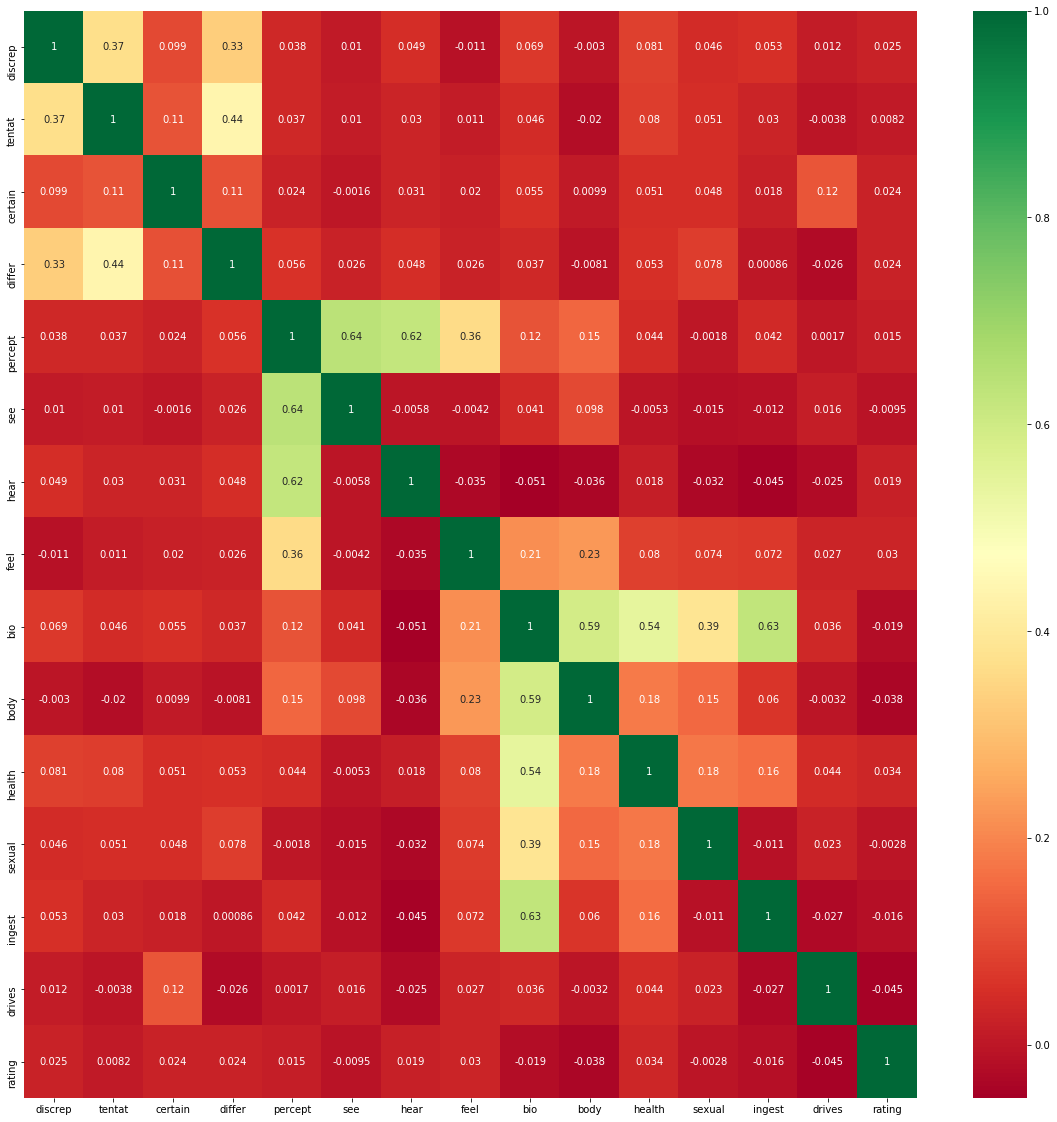

In [13]:
data = features[['discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear',
       'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives',
       'rating']]
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

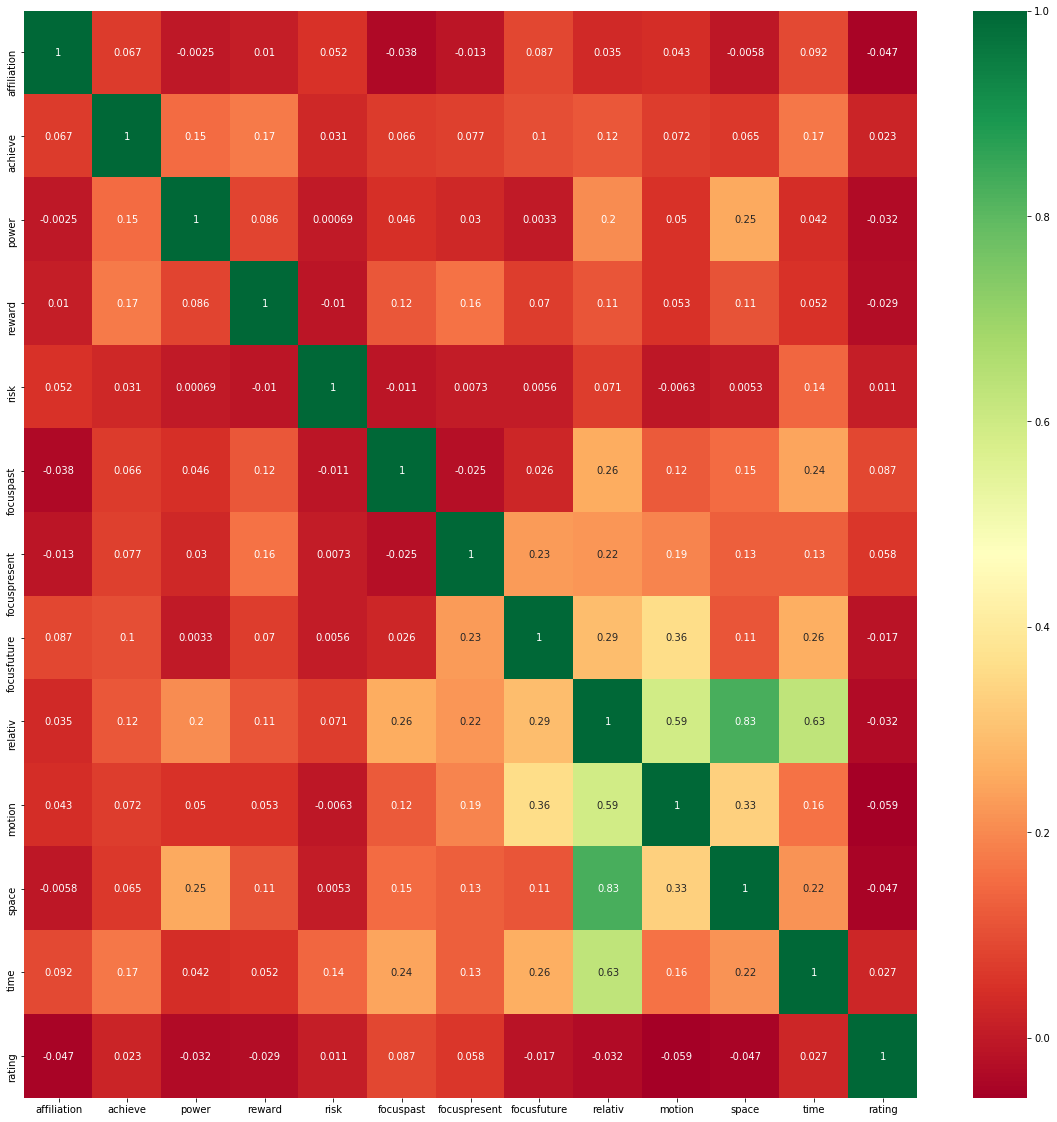

In [14]:
data = features[['affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time',
       'rating']]
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

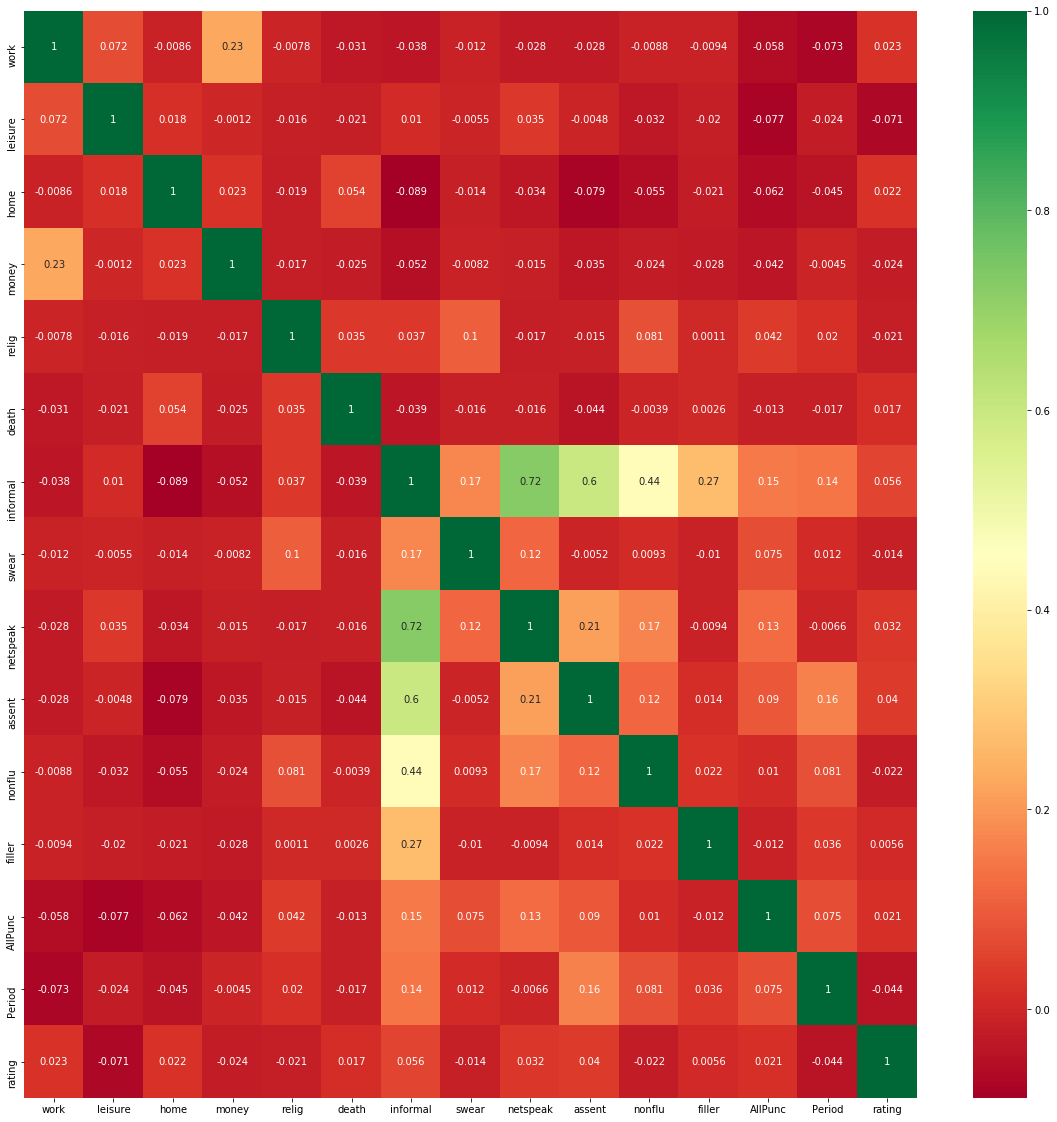

In [15]:
data = features[['work', 'leisure', 'home', 'money', 'relig', 'death', 'informal',
       'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc', 'Period',
       'rating']]
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

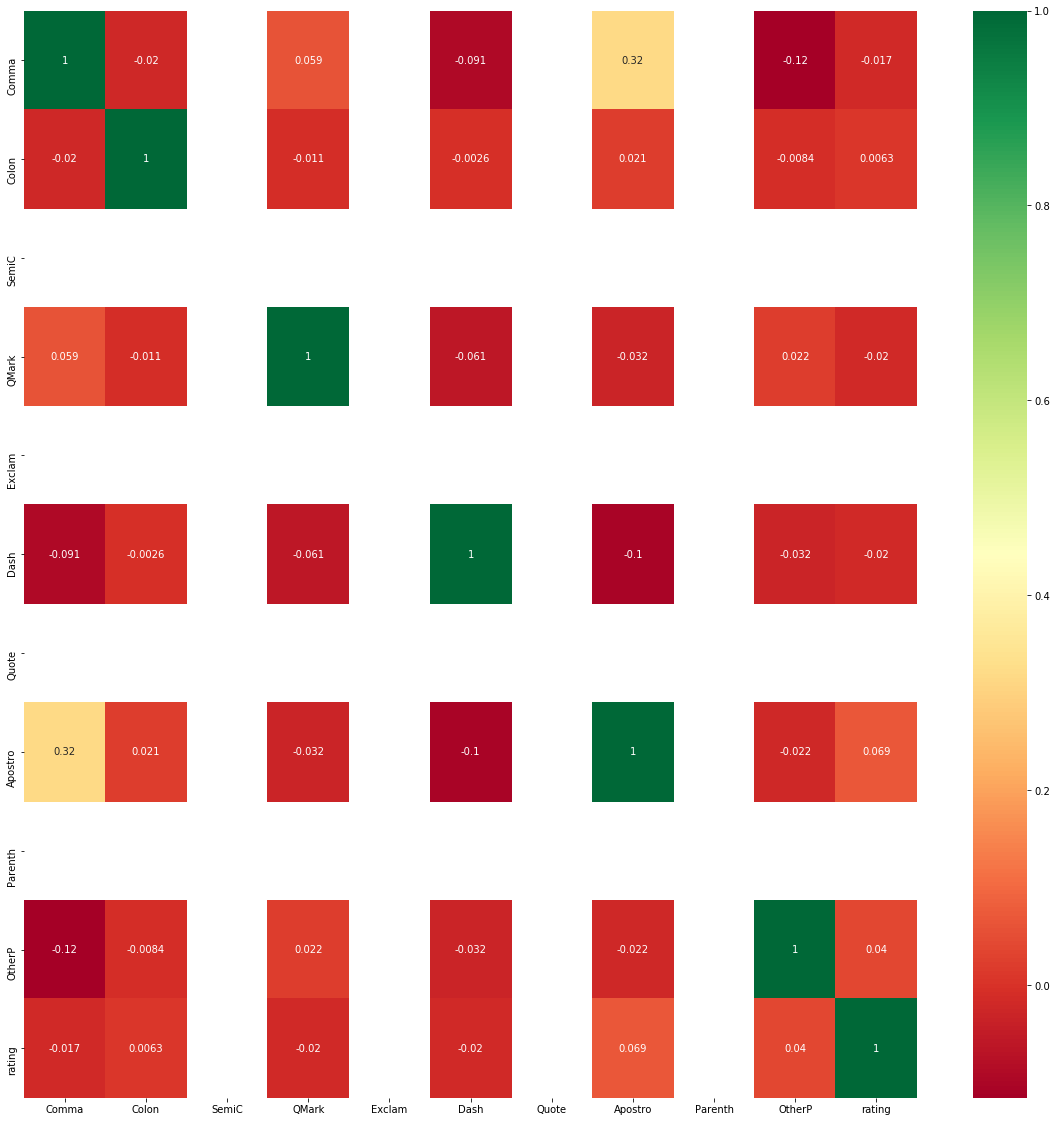

In [16]:
data = features[['Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote',
       'Apostro', 'Parenth', 'OtherP', 'rating']]
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

[0.01144852 0.01139758 0.01080917 0.01105142 0.01131112 0.01074586
 0.01262604 0.01096496 0.01078874 0.01197638 0.01215968 0.01204964
 0.01126209 0.01123648 0.01078614 0.01123121 0.01182943 0.01189141
 0.01213902 0.01153874 0.01146327 0.01117582 0.01158809 0.01064934
 0.01157649 0.01794257 0.01136916 0.01094378 0.0111036  0.01095704
 0.01117153 0.01164614 0.0111478  0.01169505 0.01104944 0.01096539
 0.01112912 0.01241135 0.01119614 0.01099539 0.01106758 0.01098074
 0.01093786 0.01118241 0.01088825 0.0112759  0.01085036 0.0113625
 0.01130605 0.01144187 0.01169555 0.01118457 0.01110536 0.01160671
 0.01115411 0.01081789 0.01131291 0.01108576 0.01116575 0.01146147
 0.01153727 0.01143528 0.01211226 0.01112678 0.01182822 0.01114568
 0.01076516 0.01118136 0.01133306 0.01138609 0.01101796 0.01170748
 0.01092766 0.01143579 0.01090345 0.01193702 0.01042627 0.01117716
 0.01203309 0.01036537 0.00651906 0.01169923 0.01083968 0.01118514
 0.00520685 0.         0.01158681 0.         0.00891117 0.
 0.0

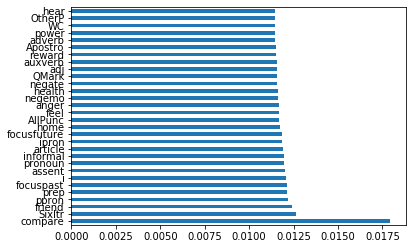

<Figure size 1080x1440 with 0 Axes>

In [17]:
X = features[['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS',
       'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you',
       'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb',
       'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
       'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social',
       'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear',
       'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives',
       'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time',
       'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal',
       'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc', 'Period',
       'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote',
       'Apostro', 'Parenth', 'OtherP']]

y = features[['rating']].to_numpy().reshape(3317,1)
labels = []
for label in y:
    if label >=0.0 and label <= 0.2:
        labels.append(0)
    elif label > 0.2 and label <= 0.4:
        labels.append(1)
    elif label > 0.4 and label <= 0.6:
        labels.append(2)
    elif label > 0.6 and label <= 0.8:
        labels.append(3)
    elif label > 0.8 and label <= 1.0:
        labels.append(4)
    else:
        print(label)

model = ExtraTreesClassifier()
model.fit(X,labels)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
plt.figure(figsize=(15,20))
plt.show()

In [22]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,labels)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(60,'Score'))  #print 10 best features

           Specs      Score
25       compare  10.533813
11             i   3.310043
84         Colon   3.134573
71          home   2.612188
62     focuspast   2.183922
9        pronoun   2.174774
10         ppron   2.158836
32           anx   2.154532
88          Dash   2.121861
6         Sixltr   1.725195
1       Analytic   1.711801
19       auxverb   1.697680
37        friend   1.690457
92        OtherP   1.544942
75      informal   1.502846
27        number   1.483202
78        assent   1.361974
0             WC   1.348443
12            we   1.324295
5            WPS   1.230917
8       function   1.202046
23          verb   1.128809
31        negemo   1.096961
36        family   1.091555
90       Apostro   1.060807
16         ipron   1.031885
50          feel   1.027645
18          prep   1.025760
52          body   0.997037
73         relig   0.934195
54        sexual   0.925343
41       insight   0.907455
40       cogproc   0.882636
80        filler   0.860728
15          they   0